# Projektvorstellung Image Classification - Kurzform

&copy; Daniel Schaudt, [Prof. Dr. Reinhold von Schwerin](https://www.thu.de/Reinhold.vonSchwerin), Technische Hochschule Ulm

In diesem Notebook findet man eine kurze Variante der Projektvorstellung ohne Erläuterungen, um **Vergleichsläufe** auf verschiedenen Rechnern durchführen zu könnnen.

### Reproduzierbarkeit erreichen

Setzen diverser [Random Seeds](https://de.wikipedia.org/wiki/Seed_key) für determistisches Trainingsverhalten (d.h. zur Reproduzierbarkeit der Ergebnisse):

In [1]:
RSEED = 1742
import random
random.seed(RSEED)
from numpy.random import seed
seed(RSEED)
from tensorflow import random as tfrand
tfrand.set_seed(RSEED)

**Bemerkung** Leider erreicht man damit nur eine *lokale Reproduzierbarkeit*, d.h. die Ergebnisse auf einem bestimmten Rechner bleiben bei auch sonst unveränderten Modellparametern (s.u.) gleich. Rechnerübergreifend kommt hier wohl zum Tragen, was [Jason Brownlee](https://machinelearningmastery.com/reproducible-results-neural-networks-keras/) im Abschnitt *Randomness from a Sophisticated Model* schreibt. Daher ist zu erwarten, das jeder, der dieses Notebook in seiner gewählten Umgebung ausführt, andere Ergebnisse erhält, als die hier dargestellten. Ohnehin sollte man Brownlees Empfehlung folgen und zur Beurteilung der Performance des Modells dieses mehrfach ausführen (siehe auch den oben verlinkten Post).

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import densenet
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import pathlib
import IPython.display as display
import PIL
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

### Laden der Bilddaten

In [3]:
data_dir = pathlib.Path('./data')

In [4]:
train_image_count = len(list(data_dir.glob('train/*/*')))
valid_image_count = len(list(data_dir.glob('valid/*/*')))

Die Klassennamen (*labels*) können aus den Ordnernamen extrahiert werden:

In [5]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('train/*')])
CLASS_NAMES

array(['covid', 'normal'], dtype='<U6')

## Data Preparation

In [6]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [7]:
BATCH_SIZE = 8
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [8]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir)+'/train',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 134 images belonging to 2 classes.


In [9]:
valid_data_gen = image_generator.flow_from_directory(directory=str(data_dir)+'/valid',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=False,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 20 images belonging to 2 classes.


Damit sind die Daten für das Training und die anschließende Validierung mit Hilfe eines neuronalen Netzes vorbereitet.

## Modeling

In [10]:
EPOCHS = 10
STEPS_PER_EPOCH = np.ceil(train_image_count/BATCH_SIZE)
VALIDATION_STEPS = np.ceil(valid_image_count/BATCH_SIZE)
INIT_LR = 5e-3

In [11]:
baseModel = densenet.DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [12]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [13]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [14]:
for layer in baseModel.layers:
    layer.trainable = False

In [15]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

In [16]:
H = model.fit(
    train_data_gen,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_data_gen,
    validation_steps=VALIDATION_STEPS,
    epochs=EPOCHS)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 17.0 steps, validate for 3.0 steps
Epoch 1/10
17/17 [==============================] - 40s 2s/step - loss: 1.3116 - accuracy: 0.6045 - val_loss: 0.6943 - val_accuracy: 0.8500
Epoch 2/10
17/17 [==============================] - 33s 2s/step - loss: 0.3500 - accuracy: 0.8284 - val_loss: 0.5831 - val_accuracy: 0.6000
Epoch 3/10
17/17 [==============================] - 34s 2s/step - loss: 0.3983 - accuracy: 0.8731 - val_loss: 0.5932 - val_accuracy: 0.7000
Epoch 4/10
17/17 [==============================] - 34s 2s/step - loss: 0.2856 - accuracy: 0.8731 - val_loss: 0.6913 - val_accuracy: 0.7500
Epoch 5/10
17/17 [==============================] - 33s 2s/step - loss: 0.2594 - accuracy: 0.9104 - val_loss: 0.5345 - val_accuracy: 0.7500
Epoch 6/10
17/17 [==============================] - 33s 2s/step - loss: 0.2140 - accuracy: 0.9254 - val_loss: 0.6943 - val_accuracy: 0.6000
Epoch 7/10
17/17 [==============================] - 35s 2s/step -

## Evaluation

In [17]:
predIdxs = model.predict(valid_data_gen)

In [18]:
predIdxs = np.argmax(predIdxs, axis=1)

In [19]:
y_valid = []
for _,labels in valid_data_gen:
    y_valid.extend(list(np.argmax(labels,axis=1)))
    if len(y_valid) == valid_image_count:
        break

In [20]:
print(classification_report(y_valid, predIdxs,target_names=CLASS_NAMES))

              precision    recall  f1-score   support

       covid       1.00      0.20      0.33        10
      normal       0.56      1.00      0.71        10

    accuracy                           0.60        20
   macro avg       0.78      0.60      0.52        20
weighted avg       0.78      0.60      0.52        20



In [21]:
cm = confusion_matrix(y_valid, predIdxs)

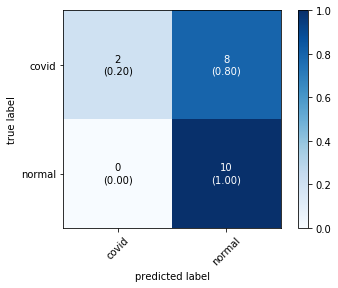

In [22]:
fig, ax = plot_confusion_matrix(conf_mat=cm, 
                                class_names=CLASS_NAMES,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

**Bewertung** Diese hängt ganz vom verwendeten Rechner ab!!!

Abschließend können die Performancemetriken des Modells während des Trainingsprozesses noch visualiert werden:

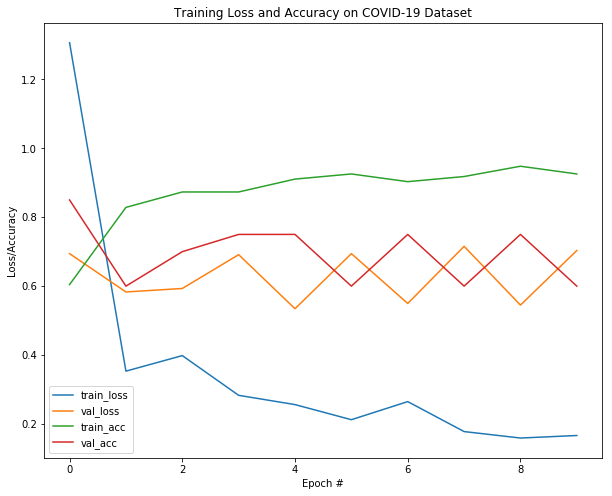

In [23]:
N = EPOCHS
#plt.style.use("ggplot")
plt.figure(figsize=(10,8))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")